In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
import cv2
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import optimizers
from keras.preprocessing import image
from PIL import Image,ImageOps
import cv2
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, ELU, Dropout, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate
import tensorflow as tf
import tensorflow.keras

from tensorflow.keras import models, layers
from tensorflow.keras.models import Model, model_from_json, Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator,  array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, SeparableConv2D, UpSampling2D, BatchNormalization, Input, GlobalAveragePooling2D

from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical

Mounted at /content/drive


In [ ]:
PARENT_DATA_DIR ='/content/drive/MyDrive/DFU Dataset/DFU Dataset Kaggle'
TRAIN_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'Train Set')
VALID_DATA_DIR = os.path.join(PARENT_DATA_DIR, 'Test Set')



['Normal', 'Foot Ulcer']


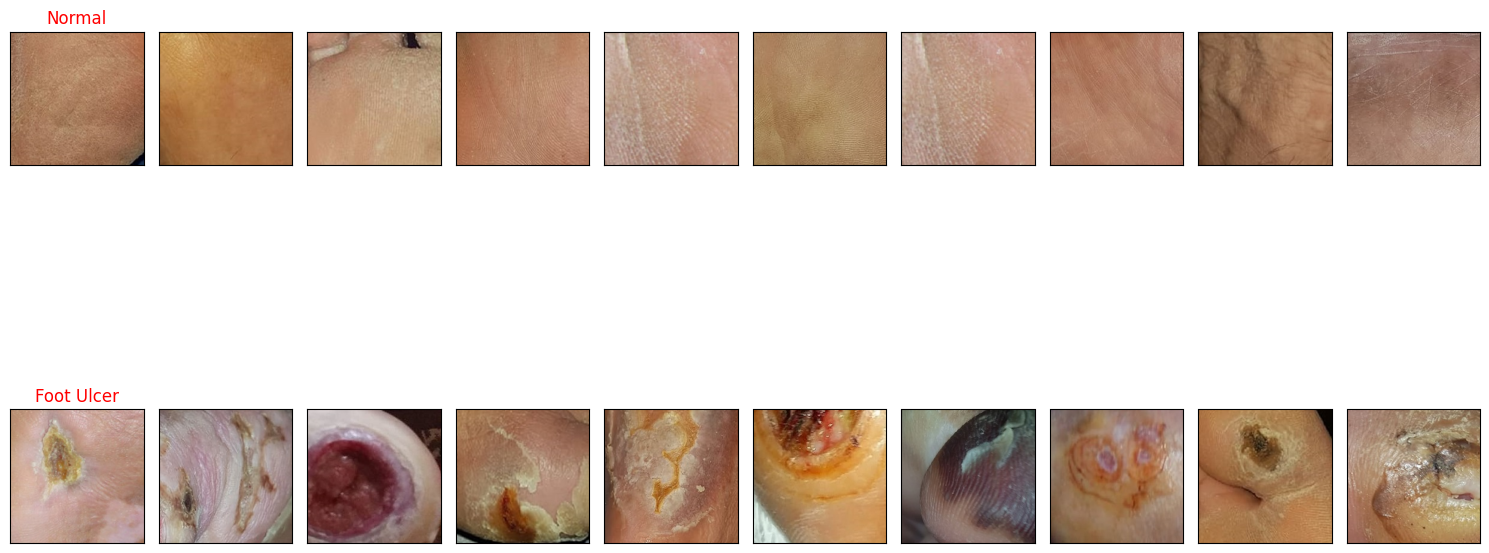

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

IMG_SIZE = 96
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
print(CATEGORIES)

classes = len(CATEGORIES)

plt.figure(figsize=(15, 10), facecolor='white')
i = 1
num_images_per_class = 10

def resize_image(img):
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

def rotate_image(img, angle=15):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    return cv2.warpAffine(img, M, (w, h))

def zoom_image(img, zoom_factor=1.15):
    h, w = img.shape[:2]
    new_h, new_w = int(h * zoom_factor), int(w * zoom_factor)
    resized = cv2.resize(img, (new_w, new_h))
    startx = new_w // 2 - w // 2
    starty = new_h // 2 - h // 2
    return resized[starty:starty+h, startx:startx+w]

def add_gaussian_noise(img, mean=0, var=0.01):
    sigma = var**0.5
    noise = np.random.normal(mean, sigma, img.shape)
    noisy = img / 255.0 + noise
    noisy = np.clip(noisy, 0, 1)
    return (noisy * 255).astype(np.uint8)

def adjust_brightness(img, factor=1.1):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    hsv = np.array(hsv, dtype=np.float64)
    hsv[..., 2] = hsv[..., 2] * factor
    hsv[..., 2][hsv[..., 2] > 255] = 255
    hsv = np.array(hsv, dtype=np.uint8)
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    image_list = os.listdir(path)
    if len(image_list) < num_images_per_class:
        continue
    random.shuffle(image_list)
    image_list = image_list[:num_images_per_class]

    for img_name in image_list:
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        # Apply data preprocessing
        img_array = resize_image(img_array)                       # 1. Resize to 96x96
        img_array = rotate_image(img_array, angle=15)            # 2. Rotate 15 degrees
        img_array = zoom_image(img_array, zoom_factor=1.15)      # 3. Zoom
        img_array = add_gaussian_noise(img_array, 0, 0.01)       # 4. Add Gaussian noise
        img_array = adjust_brightness(img_array, factor=1.1)     # 5. Brightness standardization

        white_background = 255 * np.ones((IMG_SIZE, IMG_SIZE, 3), dtype=np.uint8)
        x_offset = (white_background.shape[1] - img_array.shape[1]) // 2
        y_offset = (white_background.shape[0] - img_array.shape[0]) // 2
        white_background[y_offset:y_offset + img_array.shape[0], x_offset:x_offset + img_array.shape[1]] = img_array

        plt.subplot(len(CATEGORIES), num_images_per_class, i)
        plt.imshow(white_background)

        if i % num_images_per_class == 1:
            plt.title(c, color='red')

        plt.xticks([])
        plt.yticks([])
        i += 1

plt.tight_layout()
plt.show()


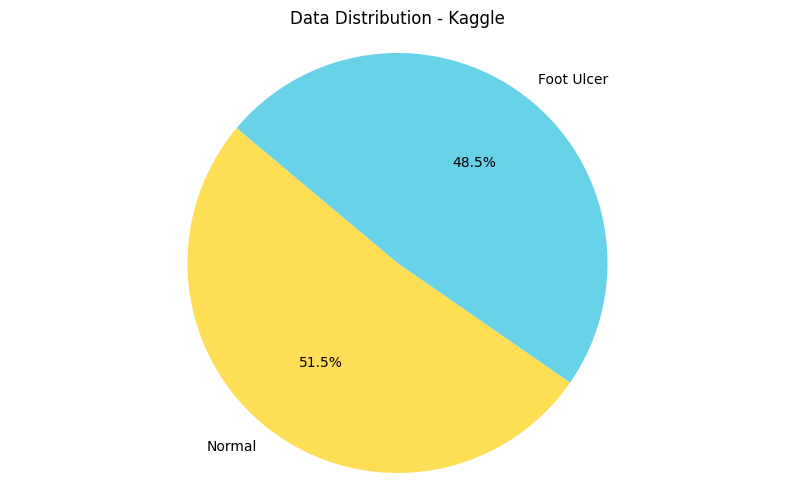

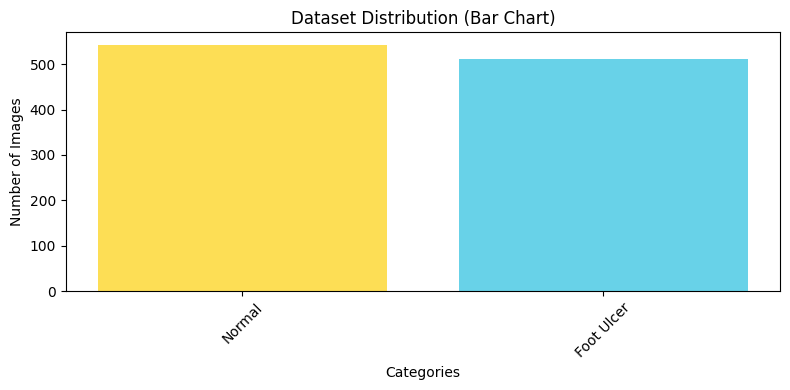

In [ ]:
category_counts = {}
for category in CATEGORIES:
    category_path = os.path.join(TRAIN_DATA_DIR, category)
    num_images = len(os.listdir(category_path))
    category_counts[category] = num_images


# Define custom colors
custom_colors = ['#FDDE55','#68D2E8','#F5F5F7']

# Plot pie chart
plt.figure(figsize=(10, 6), facecolor='white')
plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.title('Data Distribution - Kaggle')
plt.axis('equal')
plt.show()

# Plot bar chart
plt.figure(figsize=(8, 4))
plt.bar(category_counts.keys(), category_counts.values(), color=custom_colors)
plt.xlabel('Categories')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution (Bar Chart)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(training_data))

test_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c)
    class_num = CATEGORIES.index(c)
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            test_data.append([img_resized, class_num])
        except Exception as e:
            pass

print(len(test_data))

X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)

X_train = np.array(X_train).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")
X_train, X_test = X_train / 255.0, X_test / 255.0

100%|██████████| 512/512 [00:04<00:00, 106.05it/s]


1055


100%|██████████| 167/167 [00:04<00:00, 40.10it/s]


319
X_train= (1055, 96, 96, 3) Y_train= (1055,)
X_test= (319, 96, 96, 3) Y_test= (319,)


In [ ]:
pip install -q efficientnet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.7 MB/s eta 0:00:00


In [ ]:
import efficientnet.tfkeras as efn
from tensorflow.keras.callbacks import ModelCheckpoint

# Define callback to save best model
checkpoint_cb = ModelCheckpoint(
    'best_model_efficientnetb0.h5',        # File path to save the model
    monitor='val_accuracy',                # Metric to monitor
    save_best_only=True,                   # Only save model if it's the best so far
    mode='max',                            # Maximize validation accuracy
    verbose=1                              # Print message when saving
)

enet = efn.EfficientNetB0(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    weights='imagenet',
    include_top=False
)

for layer in enet.layers:
    layer.trainable = False

# Build the model
x = enet.output
x = tf.keras.layers.GlobalMaxPooling2D()(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.5)(x)
y = tf.keras.layers.Dense(classes, activation='softmax')(x)

e_model_b0 = tf.keras.Model(inputs=enet.input, outputs=y)

# Compile the model
e_model_b0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Summary of the model
e_model_b0.summary()

# Train the model with checkpoint callback
efficientnet_b0 = e_model_b0.fit(
    x=X_train,
    y=Y_train,
    epochs=200,
    validation_data=(X_test, Y_test),
    batch_size=64,
    callbacks=[checkpoint_cb]
)


16804768/16804768 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 48, 48, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 48, 48, 32)     │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 48, 48, 32)     │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 48, 48, 32)     │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 48, 48, 32)     │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 48, 48, 32)     │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand         │ (None, 1, 1, 32)       │            288 │ block1a_se_reduce[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_excite         │ (None, 48, 48, 32)     │              0 │ block1a_activation[0]… │
│ (Multiply)                │                        │                │ block1a_se_expand[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 48, 48, 16)     │            512 │ block1a_se_excite[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 48, 48, 16)     │             64 │ block1a_project_conv[… │
│ (BatchNormalization) 

 Total params: 4,379,038 (16.70 MB)

 Trainable params: 328,962 (1.25 MB)

 Non-trainable params: 4,050,076 (15.45 MB)

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.8178 - loss: 0.4026 - val_accuracy: 0.9373 - val_loss: 0.1731
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.9821 - loss: 0.0429 - val_accuracy: 0.9279 - val_loss: 0.2137
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9828 - loss: 0.0415 - val_accuracy: 0.9310 - val_loss: 0.2111
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9893 - loss: 0.0414 - val_accuracy: 0.9248 - val_loss: 0.2438
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9931 - loss: 0.0195 - val_accuracy: 0.9154 - val_loss: 0.2864
Epoch 6/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9861 - loss: 0.0336 - val_accuracy: 0.9310 - val_loss: 0.2047
Epoch 7/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9938 - loss: 0.0117 - val_accuracy: 0.9467 - val_loss: 0.1348
Epoch 8/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9964 - loss: 0.0095 - val_accuracy: 0.9

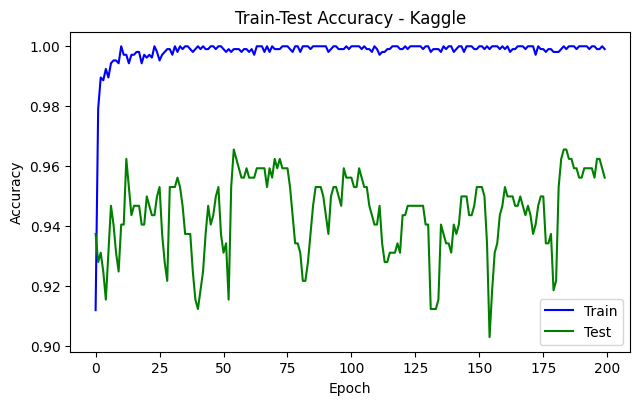

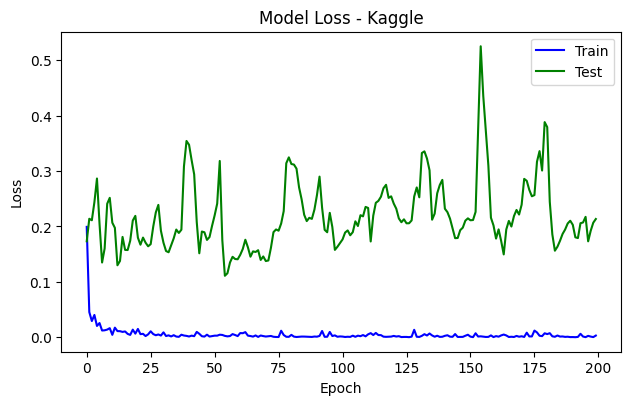

In [ ]:
import seaborn as sns
#  "Accuracy"
plt.figure(figsize=[7, 4])
plt.plot(efficientnet_b0.history['accuracy'], color="blue")
plt.plot(efficientnet_b0.history['val_accuracy'] , color="green")
plt.title('Train-Test Accuracy - Kaggle')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])
#plt.close()

# "Loss"
plt.figure(figsize=[7, 4])
plt.plot(efficientnet_b0.history['loss'], color="blue")
plt.plot(efficientnet_b0.history['val_loss'], color="green")
plt.title('Model Loss - Kaggle')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
#plt.show()
plt.gca().set_position([0.1, 0.12, 0.8, 0.8])

In [ ]:
# After training the model
# Test Loss
test_loss = efficientnet_b0.history['val_loss'][-1]  # Last epoch validation loss (test set)

print(f"Test Loss: {test_loss}")


Test Loss: 0.21333523094654083


In [ ]:
import tensorflow as tf
from sklearn.metrics import classification_report

# After training the model
# Training accuracy and validation accuracy (test set)
train_accuracy = efficientnet_b0.history['accuracy'][-1]  # Last epoch training accuracy
val_accuracy = efficientnet_b0.history['val_accuracy'][-1]  # Last epoch validation accuracy (test set)

print(f"Training Accuracy: {train_accuracy}")
print(f"Validation Accuracy (Test Accuracy): {val_accuracy}")

# Predict on test data
y_pred = e_model_b0.predict(X_test)
y_pred_classes = tf.argmax(y_pred, axis=1)  # Convert logits to class predictions

# Classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred_classes))


Training Accuracy: 0.999052107334137
Validation Accuracy (Test Accuracy): 0.9561128616333008
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 567ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96       153
           1       1.00      0.92      0.96       166

    accuracy                           0.96       319
   macro avg       0.96      0.96      0.96       319
weighted avg       0.96      0.96      0.96       319



In [ ]:
from sklearn.svm import SVC

features_train = e_model_b0.predict(X_train)
features_test = e_model_b0.predict(X_test)
features_train_flat = features_train.reshape(features_train.shape[0], -1)
features_test_flat = features_test.reshape(features_test.shape[0], -1)
svm = SVC(kernel='rbf', C=1.0, gamma='auto')
svm.fit(features_train_flat, Y_train)

33/33 ━━━━━━━━━━━━━━━━━━━━ 26s 394ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


SVC(gamma='auto')

In [ ]:
from sklearn.metrics import hinge_loss

train_accuracy = svm.score(features_train_flat, Y_train)
print(f"Train Accuracy: {train_accuracy}")

test_accuracy = svm.score(features_test_flat, Y_test)
print(f"Test Accuracy: {test_accuracy}")


if Y_train.ndim == 2:
    Y_train_integer = np.argmax(Y_train, axis=1)
else:
    Y_train_integer = Y_train

if Y_test.ndim == 2:
    Y_test_integer = np.argmax(Y_test, axis=1)
else:
    Y_test_integer = Y_test

train_loss = hinge_loss(Y_train_integer, svm.decision_function(features_train_flat))
print(f"Train Loss: {train_loss}")

test_loss = hinge_loss(Y_test_integer, svm.decision_function(features_test_flat))
print(f"Test Loss: {test_loss}")

Train Accuracy: 1.0
Test Accuracy: 0.9028213166144201
Train Loss: 1.3859730859145141e-08
Test Loss: 0.2027227695183058


In [ ]:
from sklearn.metrics import classification_report
testX_arg = np.argmax(Y_test)
y_pred = svm.predict(features_test_flat)
print(classification_report(Y_test, y_pred,  digits=7,target_names = CATEGORIES))

              precision    recall  f1-score   support

      Normal  0.8315217 1.0000000 0.9080119       153
  Foot Ulcer  1.0000000 0.8132530 0.8970100       166

    accuracy                      0.9028213       319
   macro avg  0.9157609 0.9066265 0.9025109       319
weighted avg  0.9191938 0.9028213 0.9022867       319



<Axes: title={'center': 'Confusion Matrix'}>

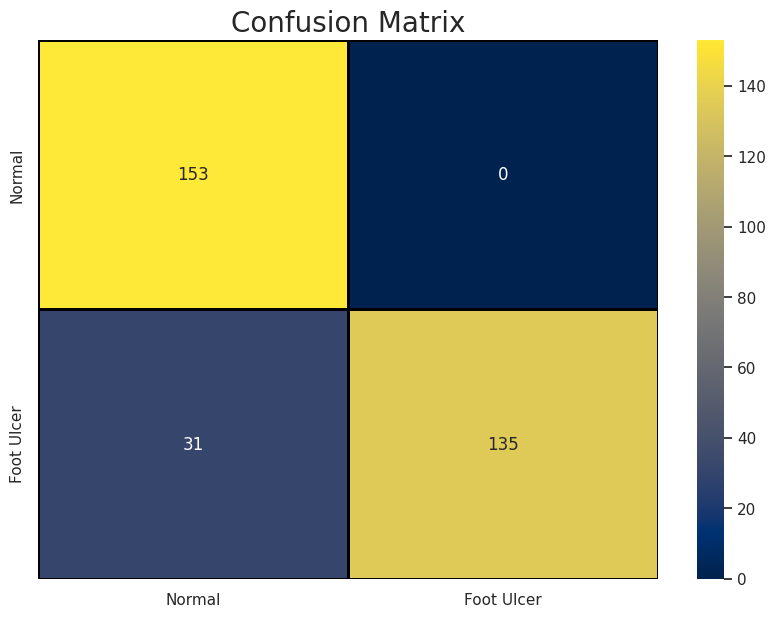

In [ ]:
import pandas as pd
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
cm = confusion_matrix(Y_test,y_pred)
cm
cm = pd.DataFrame(cm , index = CATEGORIES , columns = CATEGORIES)

plt.figure(figsize = (10,7))
ct= CATEGORIES
plt.title("Confusion Matrix", fontsize =20)
sns.heatmap(cm,cmap= "cividis", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = ct,yticklabels = ct)

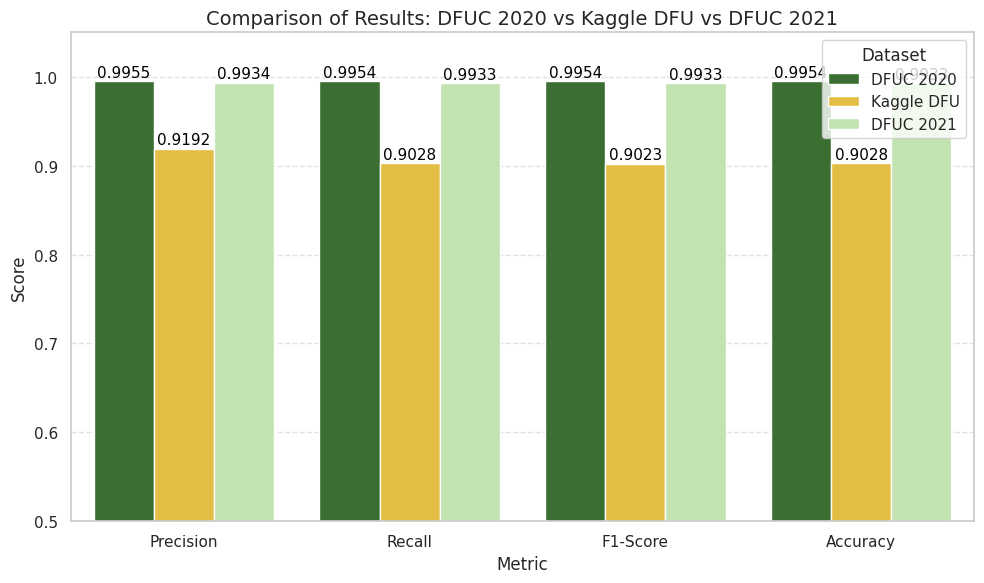

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data for 3 datasets
data = {
    'Metric': ['Precision', 'Recall', 'F1-Score', 'Accuracy'],
    'DFUC 2020': [0.9955, 0.9954, 0.9954, 0.9954],
    'Kaggle DFU': [0.9192, 0.9028, 0.9023, 0.9028],
    'DFUC 2021': [0.9934, 0.9933, 0.9933, 0.9933]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for better handling in seaborn
df_melted = pd.melt(df, id_vars=['Metric'], value_vars=['DFUC 2020', 'Kaggle DFU', 'DFUC 2021'],
                    var_name='Dataset', value_name='Score')

# Custom colors for the bars (one color per dataset)
custom_colors = ['#347928', '#FCCD2A', '#C0EBA6']  # Red, Steel Blue, Lime Green
sns.set(style="whitegrid")
# Plot setup
plt.figure(figsize=(10, 6))
plt.title('Comparison of Results: DFUC 2020 vs Kaggle DFU vs DFUC 2021', fontsize=14)

# Create a colorful barplot with custom colors
ax = sns.barplot(x='Metric', y='Score', hue='Dataset', data=df_melted, palette=custom_colors)

# Add labels and grid
plt.xlabel('Metric', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0.5, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Add value labels at the top of the bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'baseline',
                fontsize=11, color='black', xytext=(0, 3),
                textcoords='offset points')

# Show legend
plt.legend(title='Dataset')

# Show the plot
plt.tight_layout()
plt.show()
